In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import glob
size = 9
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = size

In [64]:
file =['katiestack/m101_ellipsefit_7.txt','katiestack/ngc2550a_ellipsefit_5.txt','katiestack/ngc3379_ellipsefit_3.txt', 'katiestack/ngc1275_v_bulge.txt']

# Starting Parameters
initial = np.array([(20,0.02,4)]*len(file)) #Assuming same starting parameters for each text file.
sppix = np.array([0.91, 0.93, 0.93, 0.983 ])
labels = ['(a)' , '(b)', '(c)', '(d)']

# Ranges of values to fit
a = [52, 19,0,1]
b = [96,33,96,23]

def Sersic(r, ue, re, n):
    b = 2*n - (1/3) + (4/(405*n)) + (46/(25515*n**2)) + (131/(1148175*n**3)) - (2194697/(30690717750*n**4))
    cn = (2.5/np.log(10))*b
    return ue + cn*((r/re)**(1/n) - 1)

def chisq(model_funct, model_params, x_data, y_data, y_err):
    chisqval=0
    for i in range(len(x_data)):
        chisqval += ((y_data[i] - model_funct(x_data[i], *model_params))/y_err[i])**2 
    return chisqval

(a) DW Statistic: 1.7691271183914736
(b) DW Statistic: 2.003496367610862
(c) DW Statistic: 2.3313835987799023
(d) DW Statistic: 0.3434367013171538


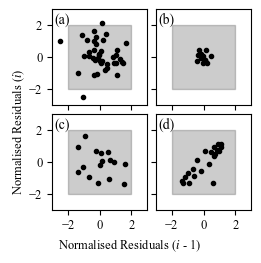

In [65]:
fig, axs = plt.subplots(ncols=2, nrows=int(len(file)/2), sharex=True, sharey=True, figsize=(2.5,2.5))
axs = axs.ravel()
residuals_all = []

# Reading Data
for i in range(len(file)):
    q = file[i].replace('/','_') # Replace / in the filename with _
    w = q.split('_') # Split up the filename with delimiter _ into a list
    name = w[1] # Name of the galaxy
    
# How many lines to skip to get data.
    data=open(file[i],'r')
    startdata='## Ellipse Parameters:'
    line = 2
    readline = True
    while readline:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == startdata:
            readline = False
        else:
            line = line + 1
    data.close()

# How many rows to read. Tried not closing/opening but code would hang.
    data=open(file[i],'r')
    points = '## Number of points:'
    l = 1
    readl = True
    while readl:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == points:
            readl = False
        else:
            l = l + 1

    npts=int(data.readline(l+1))
    data.close()

# Zero Point
    data=open(file[i],'r')
    zeropoint = '## Zero point of magnitude:'
    z = 1
    rl = True
    while rl:
        linedata=data.readline()
        linedata=linedata.strip()
        if linedata == zeropoint:
            rl = False
        else:
            z = z + 1
        
    zpt = data.readline(z+1)
    zpt = float(zpt.strip()) # file has e.g. "25.8\n" which comes with an error - removes \n
    data.close()
    
    gaia=np.genfromtxt(file[i],skip_header=line, max_rows=npts)
    radius=gaia[:,3] # MeanRad column
    radius_s = radius*sppix[i]
    counts=gaia[:,4] # Count column
    mag=zpt - 2.5*np.log10(counts) 
    
    ell = gaia[:,6]
    area = np.pi*radius**2*ell
    bright = mag + 2.5*np.log10(area)

    dev = gaia[:,7] # Dev column
    zpterr = 0.1
    err = ((2.5 * dev/(np.log(10)*counts))**2 + zpterr**2)**(1/2)
    
    radius_err = 0.01*sppix

    radius_s, bright, err = zip(*sorted(zip(radius_s, bright, err))) # Sorting data to not have weird line plots

    popt, cov = curve_fit(Sersic, # function to fit
                                     radius_s[a[i]:b[i]], # x data
                                     bright[a[i]:b[i]], # y data
                                     sigma=err[a[i]:b[i]], # set yerr as the array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial[i], # starting point for fit
                                     check_finite=True, # raise ValueError if NaN encountered (don't allow errors to pass)
                                     bounds = ((7,0.015,0), (np.inf,np.inf,20))
                         )

    residuals = np.empty(len(radius[a[i]:b[i]]))
    norm_r = np.empty(len(radius[a[i]:b[i]]))
    for j in range(len(radius[a[i]:b[i]])):
        residuals[j] = (bright[a[i]:b[i]])[j] - Sersic(radius_s[a[i]:b[i]], *popt)[j]
        norm_r[j] = residuals[j]/err[j]
    
    residuals_all = np.append(residuals_all, norm_r)

    step1 = 0
    step2 = norm_r[0]**2
    for m in range(1,len(norm_r)):
        Diff = norm_r[m] - norm_r[m-1]
        step1 = step1 + Diff**2 # Numerator, from i=2 to N
        step2 = step2 + norm_r[m]**2 # Denominator, from i=1 to N
    
    DW = step1/step2
    
    if i ==0:
        m101 = norm_r
        
    if i == 1:
        ngc2550a = norm_r
    
    if i == 2:
        ngc3379 = norm_r
        
    if i == 3:
        ngc1275 = norm_r
        
    print("{} DW Statistic: {}".format(labels[i], DW))
    
    axs[i].scatter(norm_r[:-1], norm_r[1:], color='black', label=labels[i], s=size)
    shade = np.arange(-2,3)
    axs[i].fill_between(x=shade, y1=-2, y2=2, color ='black', alpha=0.2)
    axs[i].set_xlim(-3,3)
    axs[i].set_ylim(-3,3)
    axs[i].legend(loc='upper left', markerscale=0, frameon=False, markerfirst=False, 
                  fontsize=10, borderpad=0, borderaxespad=0.2)
    
axs[0].set_xticks([-2,0,2])
fig.supxlabel("Normalised Residuals ($\it{i}$ - 1)", fontsize = size)
fig.supylabel("Normalised Residuals ($\it{i}$)", fontsize = size)

fig.tight_layout(pad=0.3)
#fig.savefig("Plots/Lag_Plot.png", dpi=600)

Text(0.02, 0.5, 'Occurence')

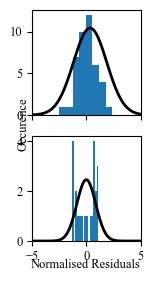

In [102]:
fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(1.4, 3))
data = [m101, ngc1275]
axs = axs.ravel()

for i in range(len(data)):
    mu, std = norm.fit(data[i])
    axs[i].hist(data[i], bins=15, density=False)
    result = np.histogram(data[i])
    dx = result[1][1] - result[1][0]
    scale = len(data[i])*dx
    x = np.linspace(-5, 5, 100)
    p = norm.pdf(x, mu, std)
    axs[i].plot(x, p*scale, 'k', linewidth=2)
    
axs[0].set_xlim(-5,5)
fig.supxlabel("Normalised Residuals", fontsize = size)
fig.supylabel("Occurence", fontsize = size)

Help on function histogram in module numpy:

histogram(a, bins=10, range=None, density=None, weights=None)
    Compute the histogram of a dataset.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines a monotonically increasing array of bin edges,
        including the rightmost edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string, it defines the method used to calculate the
        optimal bin width, as defined by `histogram_bin_edges`.
    
    range : (float, float), optional
        The lower and upper range of the bins.  If not provided, range
        is simply ``(a.min(), a.max())``.  Values outside the range are
        ignored. The fi